In [1]:
import MetaTrader5 as mt5
from datetime import datetime, timedelta
import time
import pandas as pd 
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt 
import mplfinance as mpf

import random

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import  layers
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten

In [3]:
my_account = 25008462
my_password = 'hF/LYw5wEOrI'
server = "Tickmill-Demo"

mt5.initialize(login=my_account, server=server,password=my_password)

True

In [165]:
symbol = "XAUUSD"
TIMEFRAME = mt5.TIMEFRAME_H1

df = pd.DataFrame(mt5.copy_rates_from_pos(symbol, TIMEFRAME, 0, 90000))
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace = True)
df = df[:-1]
df = df['2019':]
df = df[['open','high','low','close']]

df['pct_change'] = df['close'].pct_change() 


df['volatility'] = df['pct_change'].abs()
# Smooth the volatility with a sin wave moving average to make more easier to forecast
df['SMA_volatility'] = ta.sinwma(df['volatility'], length = 5)

df.dropna(inplace=True)
df

,open,high,low,close,pct_change,volatility,SMA_volatility
time,,,,,,,
2019-01-02 06:00:00,1282.32,1284.14,1282.09,1284.00,0.001318,0.001318,0.001006
2019-01-02 07:00:00,1283.99,1286.57,1283.78,1286.28,0.001776,0.001776,0.001170
2019-01-02 08:00:00,1286.29,1287.41,1285.68,1285.92,-0.000280,0.000280,0.001173
2019-01-02 09:00:00,1285.91,1286.54,1284.68,1285.55,-0.000288,0.000288,0.000929
2019-01-02 10:00:00,1285.53,1288.67,1284.99,1288.11,0.001991,0.001991,0.000997
...,...,...,...,...,...,...,...
2022-02-21 07:00:00,1891.83,1893.95,1890.52,1891.58,-0.000169,0.000169,0.001104
2022-02-21 08:00:00,1891.59,1892.98,1887.84,1888.04,-0.001871,0.001871,0.001187
2022-02-21 09:00:00,1887.99,1892.73,1887.61,1891.63,0.001901,0.001901,0.001381


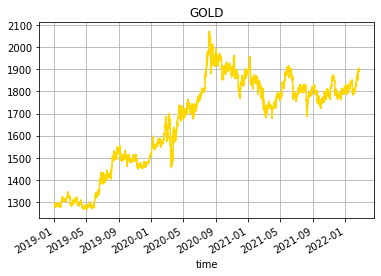

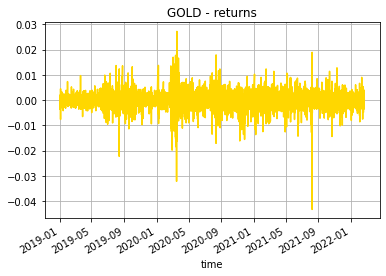

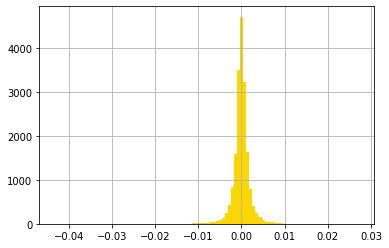


        Observations: 18549
        Mean: 2.3117529385669194e-05
        Std Deviation: 0.002010525353231406
        Variance: 4.042212195986269e-06
        Skewness: -0.917954903128148
        kurtosis: 28.06578592872857


In [172]:
df['close'].plot(color='gold')
plt.title("GOLD")
plt.grid()
plt.show()

df['pct_change'].plot(color='gold')
plt.title("GOLD - returns")
plt.grid()
plt.show()


df['pct_change'].hist(bins=100, color='gold')
plt.show()

print(f"""
        Observations: {df['pct_change'].count()}
        Mean: {df['pct_change'].mean()}
        Std Deviation: {df['pct_change'].std()}
        Variance: {df['pct_change'].var()}
        Skewness: {df['pct_change'].skew()}
        kurtosis: {df['pct_change'].kurtosis()}""")

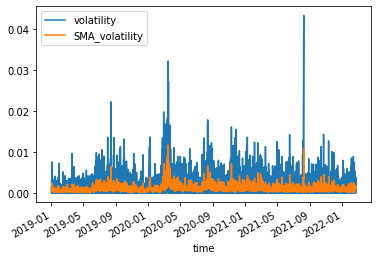

In [144]:
df[['volatility','SMA_volatility']].plot()
plt.show()

### Data Preprocessing:

In [154]:
batches = 100

x = np.array([df['SMA_volatility'].values[n-batches:n] for n in range(batches,len(df['SMA_volatility'].values))])
y = np.array([df['SMA_volatility'].values[n] for n in range(batches, len(df['SMA_volatility'].values))])

size = int(0.80 * len(df.values))

x_train = x[:size]
x_test = x[size:]

y_train = y[:size]
y_test = y[size:]

### Neural Network Architecture:

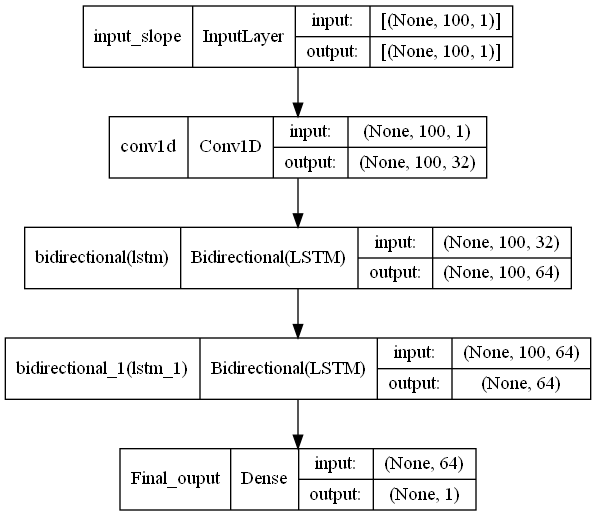

In [155]:
neral_net = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(100,1), name='input_slope'),

        tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                                strides=1, padding="causal",
                                activation="relu"),
        
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=False)),
        tf.keras.layers.Dense(1, name='Final_ouput')]) 

plot_model(neral_net, show_shapes=True)

In [156]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00125)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
neral_net.compile(optimizer=opt, loss=tf.keras.losses.MeanSquaredError(), metrics=tf.keras.metrics.RootMeanSquaredError())
tf.keras.backend.clear_session()

In [157]:
history=neral_net.fit(x = [x_train], 
                      y = [y_train],
                      batch_size=25, 
                      epochs=100, 
                      callbacks=EarlyStopping, 
                      validation_data=([x_test],  [y_test]))

Epoch 1/100
594/594 [==============================] - 123s 187ms/step - loss: 3.2991e-06 - root_mean_squared_error: 0.0018 - val_loss: 7.3689e-07 - val_root_mean_squared_error: 8.5842e-04
Epoch 2/100
594/594 [==============================] - 109s 183ms/step - loss: 1.1275e-06 - root_mean_squared_error: 0.0011 - val_loss: 1.3360e-06 - val_root_mean_squared_error: 0.0012
Epoch 3/100
594/594 [==============================] - 99s 167ms/step - loss: 8.9308e-07 - root_mean_squared_error: 9.4503e-04 - val_loss: 5.9372e-07 - val_root_mean_squared_error: 7.7053e-04
Epoch 4/100
594/594 [==============================] - 113s 190ms/step - loss: 6.9117e-07 - root_mean_squared_error: 8.3137e-04 - val_loss: 4.6378e-07 - val_root_mean_squared_error: 6.8101e-04
Epoch 5/100
594/594 [==============================] - 123s 207ms/step - loss: 5.9790e-07 - root_mean_squared_error: 7.7324e-04 - val_loss: 4.1135e-07 - val_root_mean_squared_error: 6.4137e-04
Epoch 6/100
594/594 [===========================

### Curve loss:

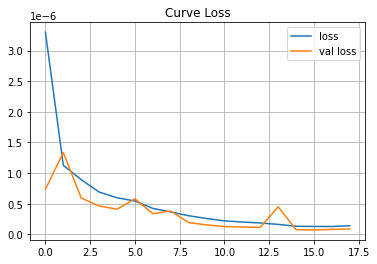

In [158]:
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Curve Loss')
plt.legend()
plt.grid()
plt.show()

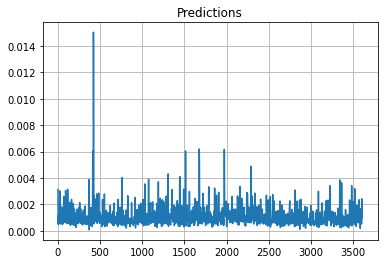

In [159]:
prediccion = neral_net.predict(x_test)

plt.plot(prediccion)
plt.title("Predictions")
plt.grid()
plt.show()

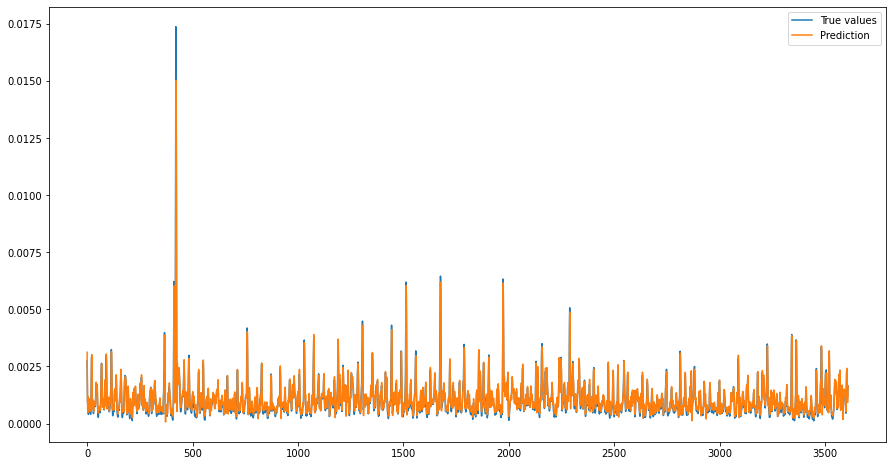

In [160]:
dataframe_test = {
    'True values':[n for n in y_test],
    'Prediction': [n[0] for n in prediccion]
}

pd.DataFrame(dataframe_test)[:].plot(figsize=(15, 8))
plt.show()

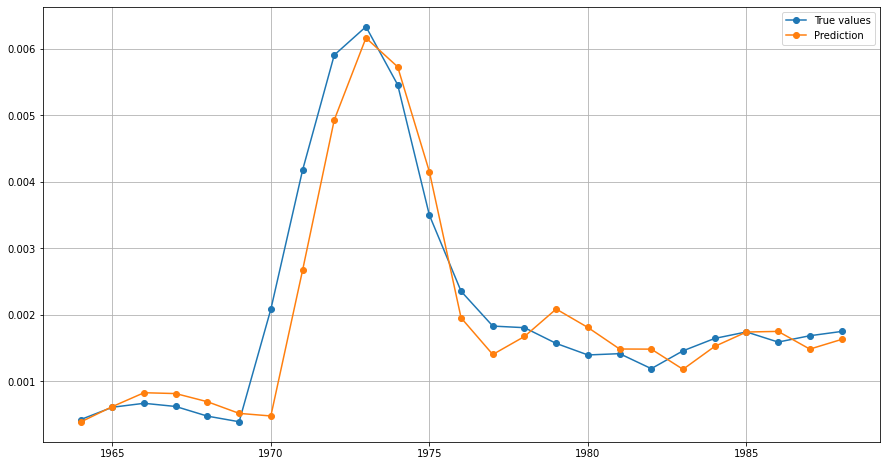

In [161]:
import random

n = random.randint(0, len(pd.DataFrame(dataframe_test))-1)
window = 25

pd.DataFrame(dataframe_test)[n:n+window].plot(figsize=(15, 8), marker="o")
plt.grid()
plt.show()

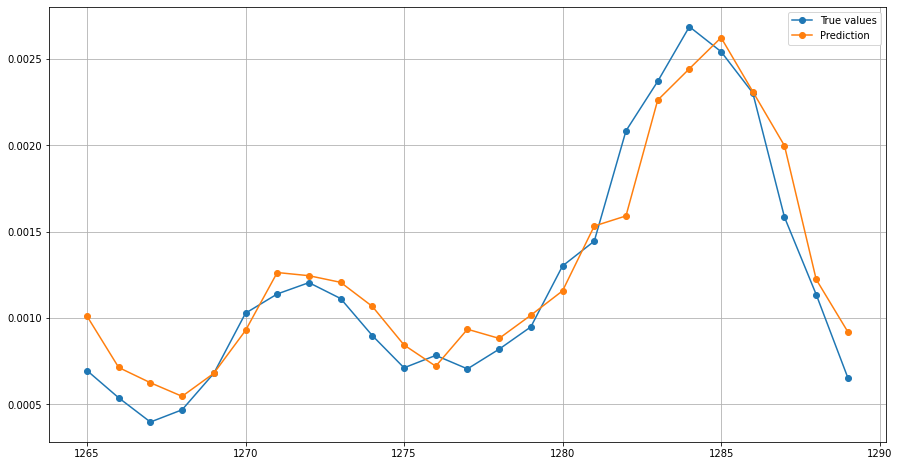

In [162]:
import random

n = random.randint(0, len(pd.DataFrame(dataframe_test))-1)
window = 25

pd.DataFrame(dataframe_test)[n:n+window].plot(figsize=(15, 8), marker="o")
plt.grid()
plt.show()

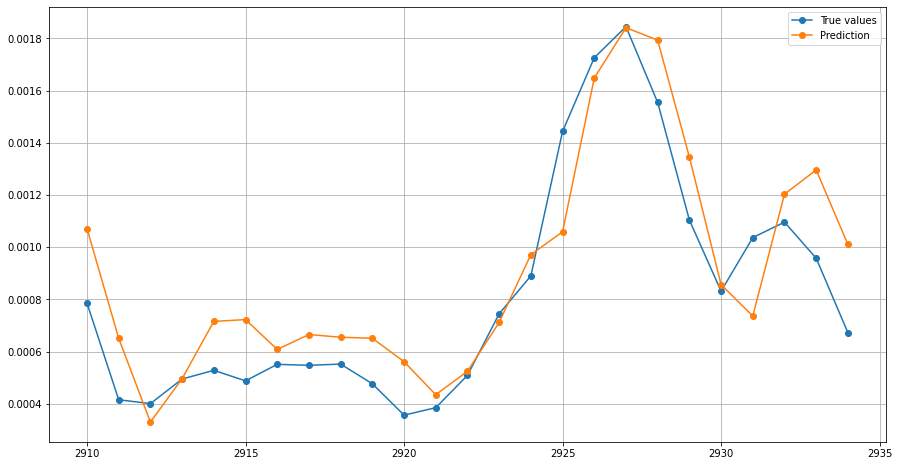

In [163]:
import random

n = random.randint(0, len(pd.DataFrame(dataframe_test))-1)
window = 25

pd.DataFrame(dataframe_test)[n:n+window].plot(figsize=(15, 8), marker="o")
plt.grid()
plt.show()